# ColabDesign STL: STL → Protein Design (Colab-ready)

This script is structured as a notebook (Jupytext style). Each `# %%` is a cell.
You can open it directly in Colab (via the Colab extension) or convert to `.ipynb`.
GPU recommended; CPU is only for smoke tests.

In [ ]:
# Configuration: edit these for your run
PATH_MODE = "helix"                     # "line" (simple z-axis), "helix", or "stl"
STL_PATH = "examples/helix.stl"        # Path to your STL (upload or generate below)
OUT_DIR = "outputs/line_smoke"         # Where to save sequence/PDB/plot
PROTEIN_LENGTH = 100
NUM_TARGET_POINTS = 100                 # For helix/line path: points along path; for STL: samples from surface
TARGET_EXTENT = 45.0                   # Å; longest dimension after scaling
LINE_LENGTH = 40.0                     # Used only when PATH_MODE="line"
SAMPLE_SEED = 0                        # -1 or None for stochastic sampling (STL only)
RUN_SEED = 0                           # Restart seed for ColabDesign
SOFT_ITERS = 200
TEMP_ITERS = 100
HARD_ITERS = 20
CHAMFER_WEIGHT = 0.025
PLDDT_WEIGHT = 1.0
PAE_WEIGHT = 0.1
USE_SQRT = False                       # True → Chamfer in Å (slightly slower)
DATA_DIR = "/content/data_dir"         # Path to AlphaFold params (set below); if None, will try AF_DATA_DIR or ../ColabDesign
AUTO_DOWNLOAD_PARAMS = True           # Set True to auto-download AF params (~3.5 GB) into DATA_DIR if missing

# Helix path parameters (used when PATH_MODE="helix")
HELIX_RADIUS = 6.0
HELIX_PITCH = 6.0
HELIX_TURNS = 2

In [2]:
# Install dependencies (Colab GPU runtime already has CUDA-enabled JAX)
import sys
import subprocess


def pip_install(*packages):
    cmd = [sys.executable, "-m", "pip", "install", "--quiet", *packages]
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)


# Core deps
pip_install("git+https://github.com/sokrypton/ColabDesign.git")
pip_install("trimesh", "py3Dmol", "matplotlib")

Running: /usr/bin/python3 -m pip install --quiet git+https://github.com/sokrypton/ColabDesign.git
Running: /usr/bin/python3 -m pip install --quiet trimesh py3Dmol matplotlib


In [3]:
# Imports and path setup
import os
from pathlib import Path
import subprocess

import numpy as np


def make_line_path(num_points: int, length: float) -> np.ndarray:
    z = np.linspace(-length / 2.0, length / 2.0, num_points, dtype=np.float32)
    zeros = np.zeros_like(z)
    return np.stack([zeros, zeros, z], axis=1)


# Repo URL (public)
REPO_URL = "https://github.com/ib565/colabdesign-stl"

# Resolve ROOT robustly (notebook-safe: __file__ may be undefined in Colab)
try:
    ROOT = Path(__file__).resolve().parents[1]
except NameError:
    ROOT = Path.cwd()

# If src/ is not present (e.g., fresh Colab), clone the repo
if not (ROOT / "src").exists():
    clone_dir = Path("/content/colabdesign-stl")
    if not clone_dir.exists():
        print(f"src/ not found; cloning {REPO_URL} into {clone_dir} ...")
        subprocess.check_call(["git", "clone", REPO_URL, str(clone_dir)])
    else:
        print(f"Using existing clone at {clone_dir}")
    ROOT = clone_dir

# Add to PYTHONPATH
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import (
    STLProteinDesigner,
    make_helix_path,
    normalize_points,
    plot_point_cloud,
    stl_to_points,
)  # noqa: E402

src/ not found; cloning https://github.com/ib565/colabdesign-stl into /content/colabdesign-stl ...


In [4]:
# Optional: Download AlphaFold params if missing (≈3.5 GB)
AF_TAR_URL = "https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar"


def ensure_af_params(data_dir: Path, auto_download: bool = False):
    data_dir.mkdir(parents=True, exist_ok=True)
    marker = data_dir / "params"
    if marker.exists() and any(marker.iterdir()):
        print(f"AlphaFold params found at: {marker}")
        return marker
    if not auto_download:
        raise FileNotFoundError(
            f"AlphaFold params not found at {marker}. "
            f"Set AUTO_DOWNLOAD_PARAMS=True to fetch (~3.5 GB) or pre-populate manually."
        )
    tar_path = data_dir / "alphafold_params_2022-12-06.tar"
    if not tar_path.exists():
        cmd = ["curl", "-L", "-o", str(tar_path), AF_TAR_URL]
        print("Downloading AF params (this may take several minutes)...")
        subprocess.check_call(cmd)
    print("Extracting params...")
    marker.mkdir(exist_ok=True)
    subprocess.check_call(["tar", "-xf", str(tar_path), "-C", str(marker)])
    print("Params ready at:", marker)
    return data_dir


# Resolve data_dir (priority: DATA_DIR → AF_DATA_DIR → ../ColabDesign)
resolved_data_dir = None
if DATA_DIR:
    resolved_data_dir = Path(DATA_DIR)
elif os.environ.get("AF_DATA_DIR"):
    resolved_data_dir = Path(os.environ["AF_DATA_DIR"])
else:
    candidate = ROOT.parent / "ColabDesign"
    resolved_data_dir = candidate if candidate.exists() else None

if resolved_data_dir is None:
    print("No AlphaFold params directory found. Set DATA_DIR or AF_DATA_DIR, or enable AUTO_DOWNLOAD_PARAMS.")
else:
    print("Using data_dir:", resolved_data_dir)
    if AUTO_DOWNLOAD_PARAMS:
        resolved_data_dir = ensure_af_params(resolved_data_dir, auto_download=True)

Using data_dir: /content/data_dir
Extracting params...
Params ready at: /content/data_dir/params


In [5]:
# Build target points (line, helix path, or STL surface samples)
target_points = None
USING_TARGET_POINTS = PATH_MODE in ("line", "helix")

if PATH_MODE == "line":
    target_points = normalize_points(
        make_line_path(num_points=NUM_TARGET_POINTS, length=LINE_LENGTH),
        target_extent=TARGET_EXTENT,
        center=True,
    )
    print("Using straight-line target points (no STL file).")
elif PATH_MODE == "helix":
    target_points = normalize_points(
        make_helix_path(
            num_points=NUM_TARGET_POINTS,
            radius=HELIX_RADIUS,
            pitch=HELIX_PITCH,
            turns=HELIX_TURNS,
        ),
        target_extent=TARGET_EXTENT,
        center=True,
    )
    print("Using helical path target points (no STL file).")
elif PATH_MODE == "stl":
    GENERATE_STL = not Path(STL_PATH).exists()

    if GENERATE_STL:
        from examples.make_helix_stl import make_helix_stl  # noqa: E402

        helix_out = Path(STL_PATH)
        helix_out.parent.mkdir(parents=True, exist_ok=True)
        make_helix_stl(
            output_path=str(helix_out),
            turns=HELIX_TURNS,
            radius=HELIX_RADIUS,
            pitch=HELIX_PITCH,
        )
        print("Generated helix STL at", helix_out)
    else:
        print("Using existing STL:", STL_PATH)
else:
    raise ValueError(f"Unknown PATH_MODE: {PATH_MODE}")

Using helical path target points (no STL file).


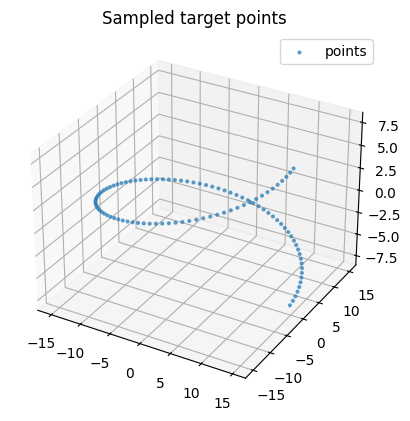

In [6]:
# Quick visualization of sampled target points (optional)
DO_POINT_PLOT = True

if DO_POINT_PLOT:
    if PATH_MODE in ("line", "helix"):
        pts = target_points
    else:
        pts = stl_to_points(
            STL_PATH,
            num_points=NUM_TARGET_POINTS,
            target_extent=TARGET_EXTENT,
            seed=SAMPLE_SEED,
        )
    plot_point_cloud(pts, title="Sampled target points", show=True, save_path=None)

In [7]:
# Run the design
out_dir = Path(OUT_DIR)
out_dir.mkdir(parents=True, exist_ok=True)

print("Initializing designer...")
designer = STLProteinDesigner(
    stl_path=None if USING_TARGET_POINTS else STL_PATH,
    target_points=target_points if USING_TARGET_POINTS else None,
    protein_length=PROTEIN_LENGTH,
    num_target_points=NUM_TARGET_POINTS,
    target_extent=TARGET_EXTENT,
    center=True,
    sample_seed=None if SAMPLE_SEED in (-1, None) else SAMPLE_SEED,
    chamfer_weight=CHAMFER_WEIGHT,
    plddt_weight=PLDDT_WEIGHT,
    pae_weight=PAE_WEIGHT,
    use_sqrt=USE_SQRT,
    data_dir=str(resolved_data_dir) if resolved_data_dir else None,
    verbose=max(1, SOFT_ITERS // 20),
)

print("Running design... (first JIT can take 30–90s on Colab GPU)")
seq = designer.design(
    soft_iters=SOFT_ITERS,
    temp_iters=TEMP_ITERS,
    hard_iters=HARD_ITERS,
    run_seed=RUN_SEED,
    save_best=True,
)

(out_dir / "sequence.txt").write_text(seq)
pdb_path = out_dir / "structure.pdb"
designer.get_structure(save_path=str(pdb_path), get_best=True)
metrics = designer.get_metrics()

print("Done.")
print(f"Sequence length: {len(seq)}")
unit = "Å" if USE_SQRT else "squared Å"
print(f"Chamfer: {metrics['chamfer']:.3f} ({unit})")
print(f"pLDDT:   {metrics['plddt']:.3f}")
print(f"PAE:     {metrics['pae']:.3f}")
print(f"PDB:     {pdb_path}")
print(f"Seq:     {out_dir / 'sequence.txt'}")

Initializing designer...
Running design... (first JIT can take 30–90s on Colab GPU)
Stage 1: running (logits → soft)
10 models [4] recycles 0 hard 0 soft 0.05 temp 1 loss 18.81 pae 0.73 con 3.57 plddt 0.36 ptm 0.31 chamfer 290.54
20 models [1] recycles 0 hard 0 soft 0.10 temp 1 loss 11.09 pae 0.49 con 0.87 plddt 0.33 ptm 0.44 chamfer 190.09
30 models [3] recycles 0 hard 0 soft 0.15 temp 1 loss 11.82 pae 0.52 con 1.18 plddt 0.36 ptm 0.42 chamfer 198.98
40 models [2] recycles 0 hard 0 soft 0.20 temp 1 loss 11.95 pae 0.41 con 0.61 plddt 0.36 ptm 0.54 chamfer 213.07
50 models [4] recycles 0 hard 0 soft 0.25 temp 1 loss 15.20 pae 0.38 con 0.31 plddt 0.38 ptm 0.58 chamfer 284.69
60 models [0] recycles 0 hard 0 soft 0.30 temp 1 loss 23.45 pae 0.75 con 4.11 plddt 0.49 ptm 0.19 chamfer 375.02
70 models [4] recycles 0 hard 0 soft 0.35 temp 1 loss 26.91 pae 0.75 con 4.10 plddt 0.41 ptm 0.18 chamfer 442.85
80 models [1] recycles 0 hard 0 soft 0.40 temp 1 loss 30.98 pae 0.76 con 4.20 plddt 0.48 ptm

In [8]:
# Overlay plot (target points vs predicted Cα)
PLOT_OVERLAY = True
if PLOT_OVERLAY:
    plot_path = out_dir / "overlay.png"
    designer.plot_overlay(save_path=str(plot_path), show=False)
    print("Overlay saved to", plot_path)

Overlay saved to outputs/line_smoke/overlay.png


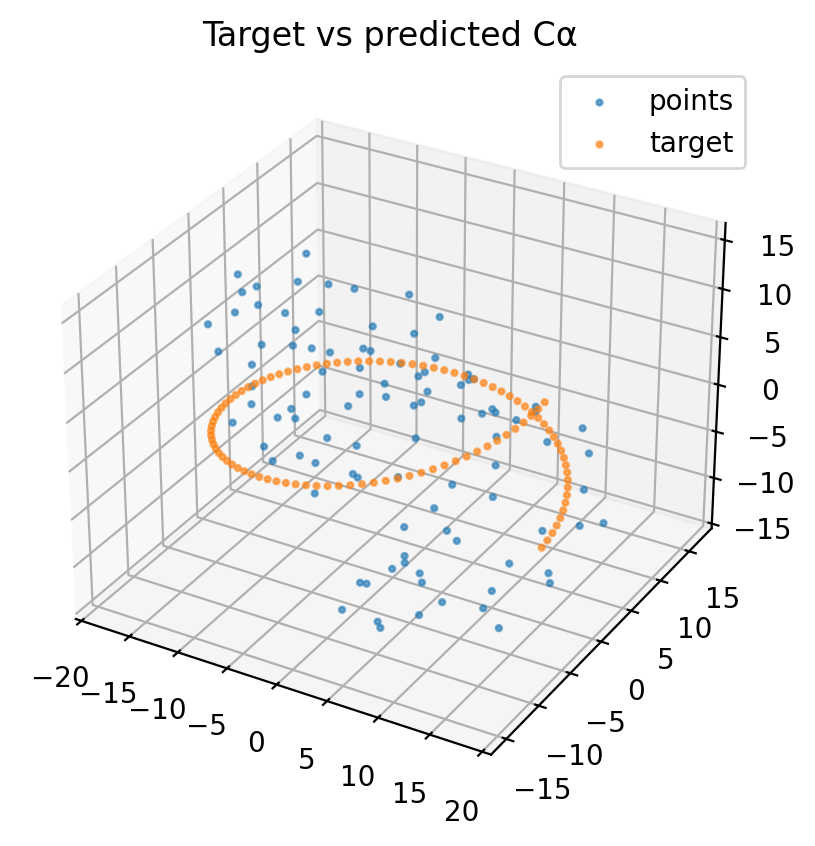

In [9]:
# display overlay here
from IPython.display import Image, display

overlay_img_path = out_dir / "overlay.png"
display(Image(filename=str(overlay_img_path)))


In [11]:
# 3D overlay with target helix points
import py3Dmol, numpy as np
from pathlib import Path

pred_ca = designer.get_ca_coords(get_best=True)
tgt = target_points if PATH_MODE in ["line", "helix"] else designer.target_points  # helix or STL points
pdb_str = Path(pdb_path).read_text()

view = py3Dmol.view(width=720, height=720)
view.addModel(pdb_str, 'pdb')
view.setStyle({'cartoon': {'color': 'skyblue', 'opacity': 0.55}})
view.addStyle({'atom': 'CA'}, {'sphere': {'color': 'deepskyblue', 'radius': 0.7}})

tgt = np.asarray(tgt, dtype=float)
xyz_body = "\n".join(f"C {x:.3f} {y:.3f} {z:.3f}" for x, y, z in tgt)
xyz_text = f"{len(tgt)}\npoints\n{xyz_body}\n"  # <-- header matters
view.addModel(xyz_text, 'xyz')
view.setStyle({'model': 1}, {'sphere': {'color': 'red', 'radius': 0.8}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# Inspect first 80 residues and path to files
print("First 80 aa:", seq[:80])
print("Outputs in:", out_dir.resolve())

First 80 aa: INEKQWWRGLKFIKCCRESLCKSNWSPRQMQMMSELHNAAYWILWECWMLFNDHHNHERAGYIFKRRWNLLRRMWHAMNR
Outputs in: /content/outputs/line_smoke


: 